In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
# from anndata import AnnData
# import pathlib
import matplotlib.pyplot as plt
# import matplotlib as mpl
# import skimage
import seaborn as sns
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


scanpy==1.10.2 anndata==0.10.8 umap==0.5.3 numpy==1.26.0 scipy==1.12.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.4 igraph==0.11.6 louvain==0.8.1 pynndescent==0.5.10
squidpy==1.6.1


In [2]:
# adata = sc.read_10x_mtx('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/mouse_kidney_visiumHD/square_008um/filtered_feature_bc_matrix')
# spatial = pd.read_parquet('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/mouse_kidney_visiumHD/square_008um/spatial/tissue_positions.parquet')

adata = sc.read_10x_mtx('/ix/djishnu/alw399/SpaceOracle/data/mouse_kidney_visiumHD/binned_outputs/square_008um/filtered_feature_bc_matrix')
spatial = pd.read_parquet('/ix/djishnu/alw399/SpaceOracle/data/mouse_kidney_visiumHD/binned_outputs/square_008um/spatial/tissue_positions.parquet')

barcodes = list(set(adata.obs_names) & set(spatial['barcode'].values))
adata = adata[barcodes, :]

spatial.set_index('barcode', inplace=True)
adata.obs = spatial.loc[barcodes]
adata.obsm['spatial'] = spatial[['pxl_row_in_fullres', 'pxl_col_in_fullres']].loc[barcodes].values

In [3]:
adata_st = adata 
adata_st

AnnData object with n_obs × n_vars = 502009 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [4]:
adata_st.layers['raw_count'] = adata_st.X.copy()

In [5]:
adata_st.X = adata_st.layers['raw_count'].copy()

sc.pp.normalize_total(adata_st, target_sum=1e4)
sc.pp.log1p(adata_st)

adata_st.layers['normalized_count'] = adata_st.X.copy()

In [6]:
sc.pp.filter_cells(adata_st, min_genes=100)
adata_st

AnnData object with n_obs × n_vars = 486782 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'raw_count', 'normalized_count'

In [7]:
mito_genes = adata_st.var_names.str.startswith('mt-')
adata_st.obs['percent_mito'] = np.sum(
    adata_st[:, mito_genes].X, axis=1).A1 / np.sum(adata_st.X, axis=1).A1
adata_st.obs['n_counts'] = adata_st.X.sum(axis=1).A1

In [8]:
adata_st = adata_st[adata_st.obs.n_genes < 2500, :]
adata_st = adata_st[adata_st.obs.percent_mito < 0.2, :]
adata_st

View of AnnData object with n_obs × n_vars = 486781 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'raw_count', 'normalized_count'

In [9]:
# # divide adata into 10 different subsets
# # in order to ensure the reference is good, make sure we are randomly subsampling 

# import itertools
# np.random.seed(42) 

# n_subsets = 10
# barcodes = adata_st.obs_names.tolist()
# subset_size = len(barcodes) // n_subsets
# remainder = len(barcodes) % n_subsets

# subset_labels = list(itertools.chain(
#     *[[i] * subset_size for i in range(n_subsets)] 
#     + [[n_subsets - 1] * remainder]              
# ))

# adata_st.obs['subset'] = subset_labels
# adata_st.obs['subset'].value_counts()


In [10]:
# adata_sc = sc.read_h5ad('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/mouse_kidney_survey/mouse_kidney_13.h5ad')
adata_sc = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
# adata_sc.obs['cluster'] = adata_sc.obs['ct1']
adata_sc

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [11]:
[x for x in adata_sc.var_names if not x[0].isupper()]

['ccdc198']

In [12]:
adata_sc.X = adata_sc.layers['normalized_count']

In [13]:
celltypes = adata_sc.obs['ct3'].unique()

# ct3 is finer resolution than cell_types, which CO GRN and COMMOT LRs use

mapping = {}
for ct3 in celltypes:
    value = adata_sc[adata_sc.obs['ct3'] == ct3].obs['cell_type'].drop_duplicates().iloc[0]
    mapping[ct3] = value

adata_sc.obs['cell_type'].value_counts()

cell_type
Myeloid                5266
Endothelial            1779
Epithelial              462
B                       442
T                       361
Mesenchymal_Stromal     128
NK                       71
Name: count, dtype: int64

In [14]:
# shared_genes = list(set(adata_sc.var_names) & set(adata_st.var_names))
# len(shared_genes)

In [15]:
# adata_sc = adata_sc[:, shared_genes]
# adata_st = adata_st[:, shared_genes]

In [16]:
adata_sc.X.max(), adata_st.X.max()

(7.434651, 8.188613)

In [17]:
sc.tl.rank_genes_groups(adata_sc, groupby="ct3", use_raw=False, layer='normalized_count')
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
hv_markers = list(np.unique(markers_df.melt().value.values))
len(hv_markers)

1748

In [18]:
import decoupler as dc

markers = dc.get_resource(
    name='PanglaoDB',
    organism='mouse',
    license='academic'
)
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['mouse_sensitivity'].astype(float) > 0.5)]
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers = markers[markers['organ'] == 'Kidney']
kidney_markers = markers['genesymbol'].values
len(kidney_markers)

64

In [19]:
markers = list(set(hv_markers) | set(kidney_markers))
len(markers)

1766

In [20]:
# tg.pp_adatas(adata_sc, adata_st, genes=markers['genesymbol'].values)
tg.pp_adatas(adata_sc, adata_st, genes=markers)

1718 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
2978 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [21]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    # mode="cells",
    mode="clusters",
    # cluster_label='cell_type',  # .obs field w cell types
    cluster_label='ct3',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
    device="cuda:0",
    # device='cpu',
    # device='mps'
)

Allocate tensors for mapping.
Begin training with 1718 genes and rna_count_based density_prior in clusters mode...
Printing scores every 100 epochs.


Score: 0.128, KL reg: 0.122
Score: 0.210, KL reg: 0.001
Score: 0.215, KL reg: 0.001
Score: 0.217, KL reg: 0.001
Score: 0.218, KL reg: 0.001


Saving results..


In [22]:
# from tqdm import tqdm 

# for subset_idx in tqdm(range(n_subsets)):
#     adata_subset = adata_st[adata_st.obs['subset'] == subset_idx, :]

#     tg.pp_adatas(adata_sc, adata_subset, genes=markers['genesymbol'])

#     ad_map = tg.map_cells_to_space(adata_sc, adata_subset,
#         mode="cells",
#         # mode="clusters",
#         # cluster_label='cell_type',  # .obs field w cell types
#         # cluster_label='ct3',  # .obs field w cell types
#         density_prior='rna_count_based',
#         num_epochs=500,
#         device="cuda:0",
#         # device='cpu',
#         # device='mps'
#     )
        
#     ad_map.write(f'/ix/djishnu/shared/djishnu_kor11/tangram_outputs/mouse_kidney_visiumHD/ad_map_{subset_idx}.h5ad')

In [23]:
# # Stich subsets back together again 
# from glob import glob 

# ad_maps = glob('/ix/djishnu/shared/djishnu_kor11/tangram_outputs/mouse_kidney_visiumHD/ad_map*.h5ad')

# # vars are st_adata barcodes and obs are reference cells
# ad_maps = [sc.read_h5ad(f) for f in ad_maps]
# ad_maps[0]


In [24]:
# ad_map = sc.concat(ad_maps, axis=1)
# ad_map

In [25]:
# ad_map.obs = ad_maps[0].obs
# ad_map

In [26]:
# ad_map = ad_map[:, adata_st.obs_names]
# ad_map

In [27]:
# tg.project_cell_annotations(ad_map, adata_st, annotation="cell_type")
tg.project_cell_annotations(ad_map, adata_st, annotation="ct3") 

spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


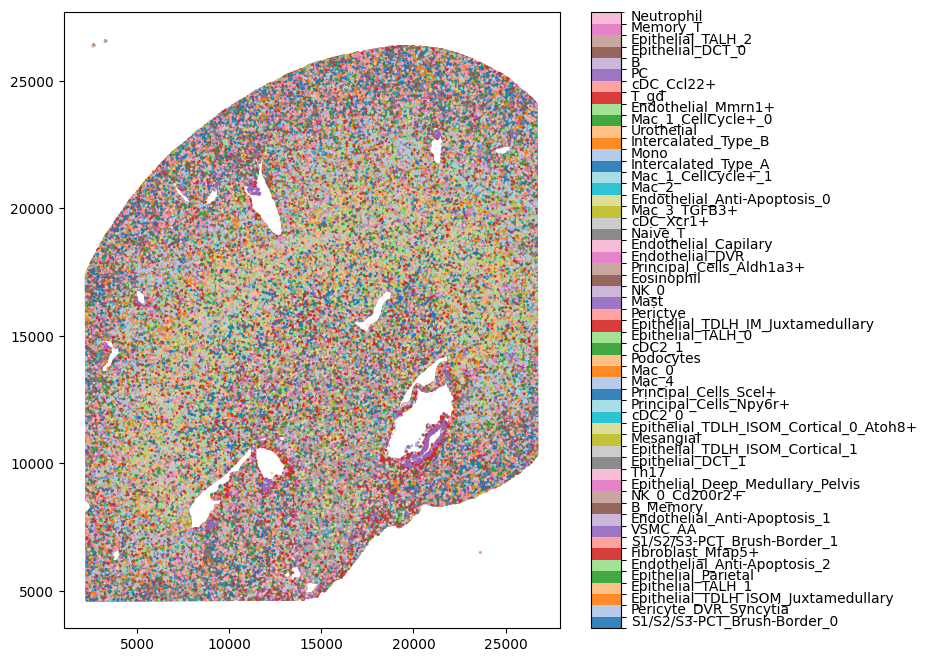

In [28]:
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
unique_cell_types = adata_st.obs['predicted'].unique()
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

# Create a numeric representation of the predicted cell types
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['predicted'].map(cell_type_to_numeric)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
cmap = ListedColormap(sns.color_palette("tab20", len(unique_cell_types)).as_hex())
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

plt.figure(figsize=(8,8))
# Plot the scatter plot
plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

# Create a color bar with cell type labels
cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types)


for label in cbar.ax.get_yticklabels():
    label.set_verticalalignment('bottom')  # Change alignment
    label.set_y(label.get_position()[1] + 0.05)  # Adjust y-position (move up)

plt.show()


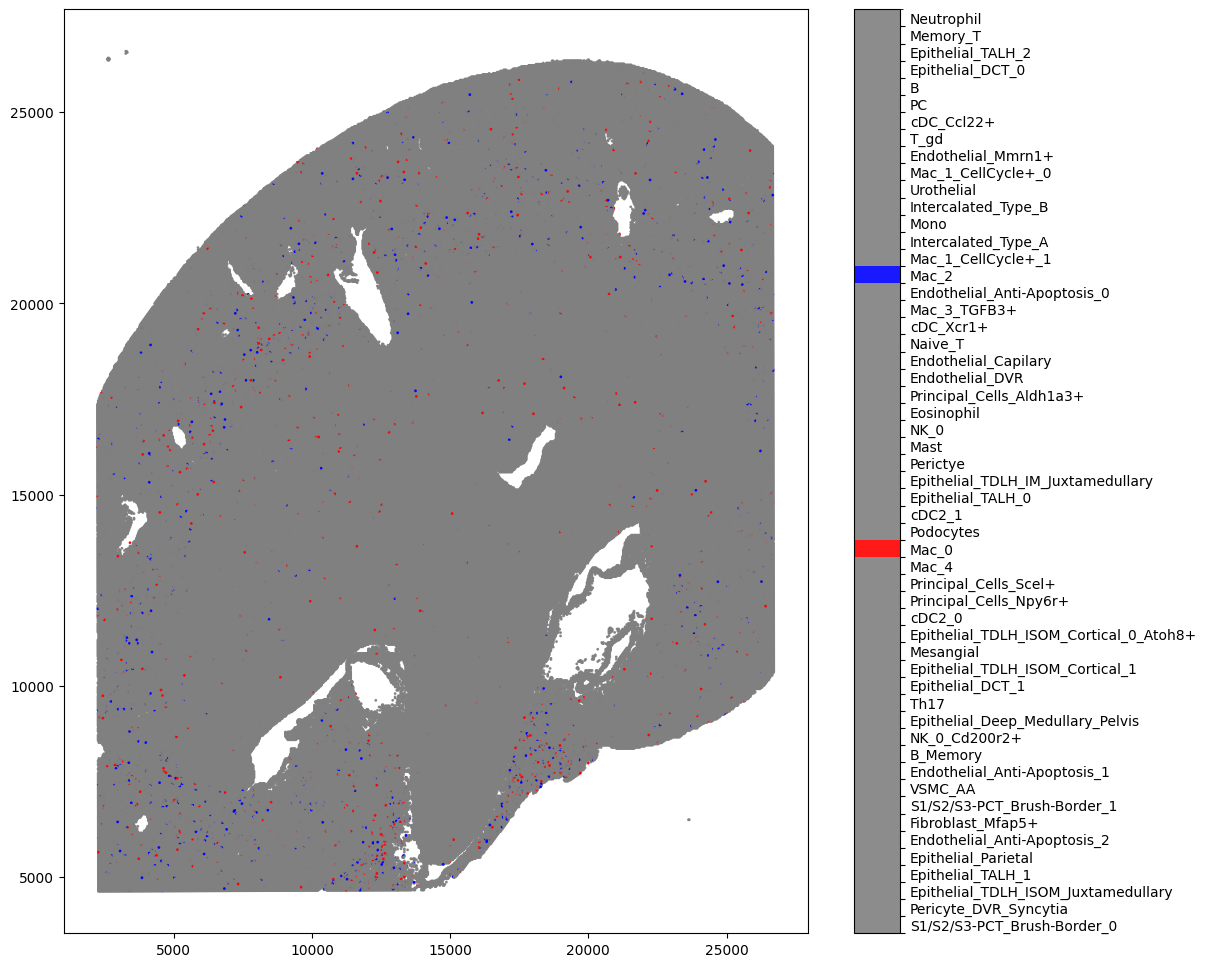

In [29]:
plt.figure(figsize=(12, 12))
unique_cell_types = adata_st.obs['predicted'].unique()
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['predicted'].map(cell_type_to_numeric)

colors = ['gray'] * len(unique_cell_types)
if 'Mac_0' in cell_type_to_numeric:
    colors[cell_type_to_numeric['Mac_0']] = 'red'
if 'Mac_2' in cell_type_to_numeric:
    colors[cell_type_to_numeric['Mac_2']] = 'blue'
cmap = ListedColormap(colors)
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types )

for label in cbar.ax.get_yticklabels():
    label.set_verticalalignment('bottom')  # Change alignment
    label.set_y(label.get_position()[1] + 0.05)  # Adjust y-position (move up)

plt.show()


In [30]:
adata_st.obs['predicted'].value_counts()

predicted
S1/S2/S3-PCT_Brush-Border_1               24708
Mac_4                                     23073
Epithelial_TALH_1                         20468
S1/S2/S3-PCT_Brush-Border_0               20320
Epithelial_TALH_0                         20201
Epithelial_TDLH_IM_Juxtamedullary         13813
Principal_Cells_Scel+                     13622
Epithelial_TDLH_ISOM_Juxtamedullary       13537
Epithelial_Parietal                       12827
Mesangial                                 11860
Th17                                      11788
Principal_Cells_Aldh1a3+                  11626
Eosinophil                                11250
B_Memory                                  10996
Pericyte_DVR_Syncytia                     10995
Epithelial_Deep_Medullary_Pelvis          10653
cDC2_0                                    10389
Endothelial_Anti-Apoptosis_1              10360
Endothelial_Anti-Apoptosis_0              10152
Perictye                                  10090
Fibroblast_Mfap5+             

In [31]:
# adata_st.obs['predicted'].to_csv('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/mouse_kidney_visiumHD/tangram_annotations.csv')

In [32]:
# Don't do this to see how well beta transfers

# ad_ge = tg.project_genes(
#                   ad_map, 
#                   adata_sc,
#                   cluster_label='ct3')

# del(adata_sc) # make space because running locally
# del(adata)
# import gc
# gc.collect()

In [33]:
# ad_ge

In [34]:
# ad_ge.layers['raw_count'] = adata_st.to_df().reindex(ad_ge.var_names, axis=1).fillna(0)
# ad_ge

In [35]:
# we don't need genes that we didn't train on 

adata_st = adata_st[:, list(set(adata_sc.var_names) & set(adata_st.var_names))]
adata = adata[:, list(set(adata_sc.var_names) & set(adata.var_names))]

In [36]:
# also add zero-value genes that weren't measured (but in reference)

missing_genes = list(set(adata_sc.var_names) - set(adata_st.var_names))
len(missing_genes)

80

In [46]:
zeros = np.zeros((adata_st.X.shape[0], len(missing_genes)))
tmp = sc.AnnData(
    X = np.concatenate([adata_st.X.toarray(), zeros], axis=1),
    obs = adata_st.obs,
    obsm = adata_st.obsm,
    layers = {
        'raw_count': np.concatenate([adata_st.layers['raw_count'].toarray(), zeros], axis=1),
        'normalized_count': np.concatenate([adata_st.layers['normalized_count'].toarray(), zeros], axis=1),
    },
    var = pd.DataFrame(index=pd.Index(list(adata_st.var_names) + missing_genes))
)
tmp

AnnData object with n_obs × n_vars = 486781 × 3058
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes', 'percent_mito', 'n_counts', 'uniform_density', 'rna_count_based_density', 'predicted', 'predicted_numeric'
    obsm: 'spatial', 'tangram_ct_pred'
    layers: 'raw_count', 'normalized_count'

In [47]:
adata_st = tmp

In [49]:
# this one gene in the reference is not capitalized??
adata_st.var_names = [name.capitalize() if name != 'ccdc198' else name for name in adata_st.var_names]

In [50]:
adata_st.obs['ct3'] = adata_st.obs['predicted']
adata_st.obs['cell_type'] = adata_st.obs['ct3'].map(mapping)
adata_st.obs['cell_type'].value_counts()

cell_type
Epithelial             233984
Myeloid                 95489
Mesenchymal_Stromal     50988
Endothelial             48700
T                       29736
B                       17825
NK                      10059
Name: count, dtype: int64

In [51]:
adata_sc.obs['cell_type'].value_counts()

cell_type
Myeloid                5266
Endothelial            1779
Epithelial              462
B                       442
T                       361
Mesenchymal_Stromal     128
NK                       71
Name: count, dtype: int64

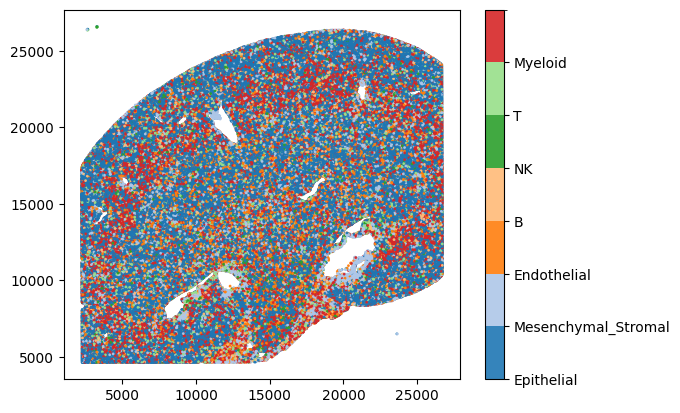

In [52]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
unique_cell_types = adata_st.obs['cell_type'].unique()

# Create a numeric representation of the predicted cell types
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['cell_type'].map(cell_type_to_numeric)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
cmap = ListedColormap(sns.color_palette("tab20", len(unique_cell_types)).as_hex())
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

# Plot the scatter plot
plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

# Create a color bar with cell type labels
cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types)

plt.show()


In [53]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.utils import clean_up_adata
from spaceoracle.tools.network import encode_labels
from spaceoracle.tools.utils import scale_adata

adata_st = scale_adata(adata_st, cell_size=8)
adata_st


AnnData object with n_obs × n_vars = 486781 × 3058
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes', 'percent_mito', 'n_counts', 'uniform_density', 'rna_count_based_density', 'predicted', 'predicted_numeric', 'ct3', 'cell_type'
    obsm: 'spatial', 'tangram_ct_pred', 'spatial_unscaled'
    layers: 'raw_count', 'normalized_count'

In [54]:
adata_st.obs['cell_type'] = adata_st.obs['cell_type'].astype('category')
adata_st.obs['cell_type_int'] = adata_st.obs['cell_type'].apply(
    lambda x: encode_labels(adata_st.obs['cell_type'], reverse_dict=True)[x])


In [55]:
clean_up_adata(adata_st, ['cell_type', 'cell_type_int', 'spatial', 'ct3'])
adata_st


AnnData object with n_obs × n_vars = 486781 × 3058
    obs: 'ct3', 'cell_type', 'cell_type_int'
    obsm: 'spatial', 'tangram_ct_pred', 'spatial_unscaled'
    layers: 'raw_count', 'normalized_count'

In [56]:
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.utils import scale_adata

adata.X = adata.layers['normalized_count']

pcs = BaseTravLR.perform_PCA(adata_st)
BaseTravLR.knn_imputation(adata_st, pcs, method='MAGIC')


: 

: 

In [ ]:
adata_st.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_visium.h5ad')

In [ ]:
# adata_st.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_visium.h5ad')
